In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
images_path = '/kaggle/input/airbus-ship-detection/train_v2'
csv_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'

In [3]:
df = pd.read_csv(csv_path)
print("Dataframe size:", df.shape)
print(df.head())


Dataframe size: (231723, 2)
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Download CSV with data
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Clear data from rows with NaN in the EncodedPixels column
df_cleaned = df.dropna(subset=['EncodedPixels'])

# Counting the number of ships in each image
ship_counts = df_cleaned.groupby('ImageId').size()

# Display the number of ships for each image
print(ship_counts)


ImageId
000155de5.jpg    1
000194a2d.jpg    5
00021ddc3.jpg    9
0002756f7.jpg    2
00031f145.jpg    1
                ..
fff77c602.jpg    1
fff909871.jpg    1
fffcb6464.jpg    1
fffd924fb.jpg    2
fffdd2377.jpg    1
Length: 42556, dtype: int64


In [5]:
df_cleaned

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


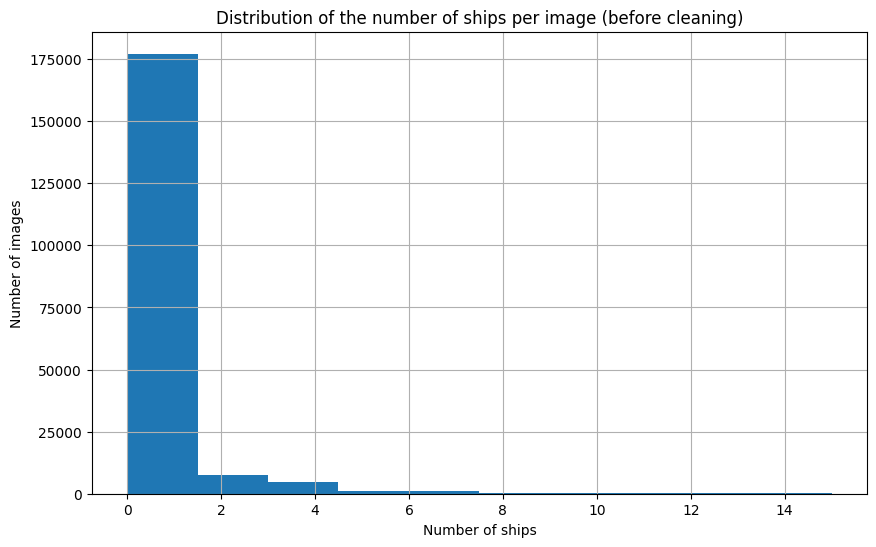

In [6]:
df['ships_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# Visualization of the distribution of the number of ships
ship_counts = df.groupby('ImageId')['ships_count'].max()
plt.figure(figsize=(10, 6))
ship_counts.hist(bins=10)
plt.title('Distribution of the number of ships per image (before cleaning)')
plt.xlabel('Number of ships')
plt.ylabel('Number of images')
plt.show()

Number of images with ships: 42556


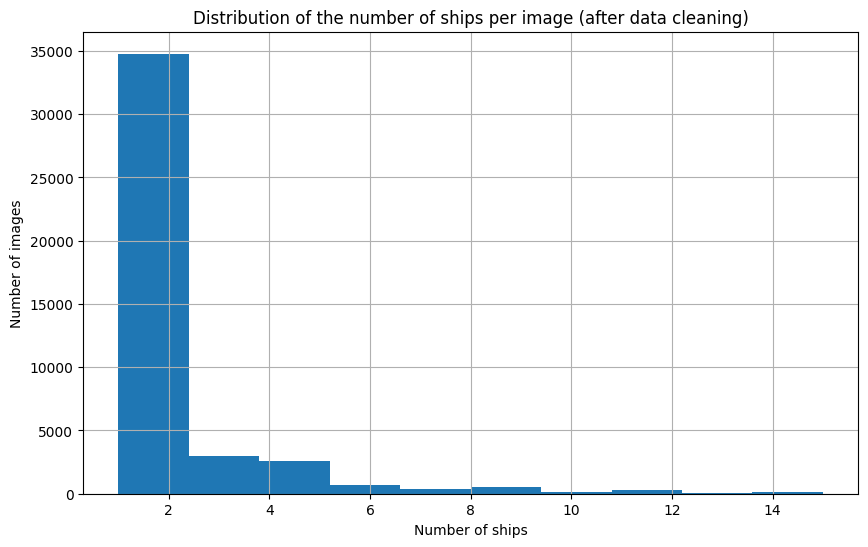

In [7]:
# Clear data from rows with NaN in the EncodedPixels column
df_cleaned = df.dropna(subset=['EncodedPixels']).reset_index(drop=True)

# Number of unique images with ships
unique_images_with_ships = df_cleaned['ImageId'].nunique()

# Counting the number of ships in each image (group by ImageId)
ship_counts = df_cleaned.groupby('ImageId').size()

# Output of number of unique images with ships
print("Number of images with ships:", unique_images_with_ships)

# Visualization of the distribution of the number of ships in each image
plt.figure(figsize=(10, 6))
ship_counts.hist(bins=10)
plt.title('Distribution of the number of ships per image (after data cleaning)')
plt.xlabel('Number of ships')
plt.ylabel('Number of images')
plt.show()

In [8]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=aded7f95f762398bf74e121e3473ea91498be206b57d9dbf459bb865397143c7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6df6f4595999041deba13cc75bfa649cc6d1cbf2ec6ecfe9edb22258922f2d7d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


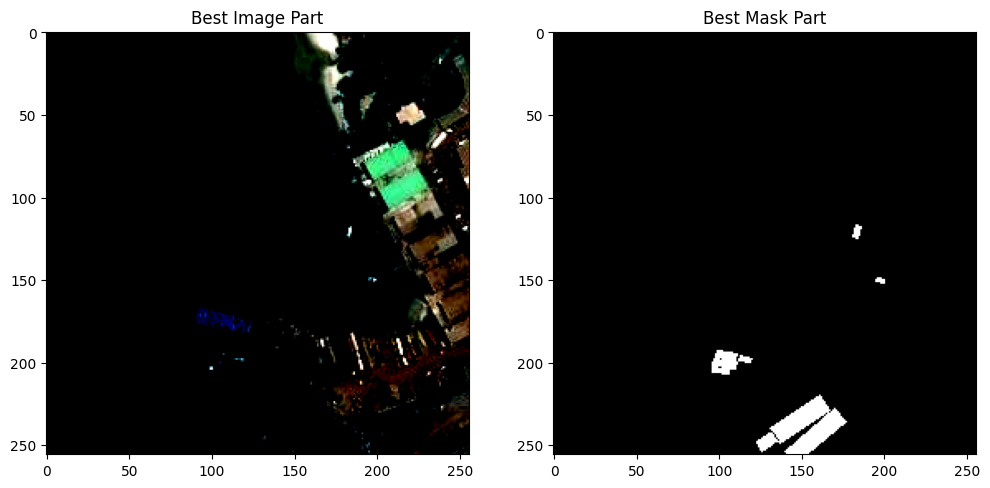

In [26]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class ShipDataset(Dataset):
    def __init__(self, images_path, df_cleaned, height=768, width=768, image_ids=None):
        self.images_path = images_path
        self.df_cleaned = df_cleaned
        self.height = height
        self.width = width
        self.image_ids = image_ids if image_ids is not None else df_cleaned['ImageId'].unique()
        
    def __len__(self):
        return len(self.image_ids)
    
    def rle_to_mask(self, rle, height, width):
        """
        Converts Run-Length Encoding to a height x width mask.
        :param rle: string containing Run-Length Encoding (pairs start, length)
        :param height: height of the mask
        :param width: width of the mask
        :return: mask in the form of a numpy array
        """
        mask = np.zeros(height * width, dtype=np.uint8)  # the mask is initially empty
        rle_values = list(map(int, rle.split()))  # divide the string into numbers
        
        for i in range(0, len(rle_values), 2):
            start = rle_values[i] - 1  # the starting pixel
            length = rle_values[i+1]  # segment length
            
            # translate the linear index into two-dimensional coordinates (row, column)
            start_row = start // width
            start_col = start % width
            
            # Fill the mask with the appropriate pixels
            for j in range(length):
                row = (start + j) // width  
                col = (start + j) % width 
                
                # Checking whether we are not going beyond the mask
                if row < height and col < width:
                    mask[row * width + col] = 1  # set the pixel to 1

        return mask.reshape((height, width)).T  # convert the mask into 2D format (height, width)

    def combine_masks(self, masks, height, width):
        """
        Combines masks for several ships into one
        """
        if masks:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
            for mask in masks:
                combined_mask = np.maximum(combined_mask, mask)
        else:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
        return combined_mask
    
    def split_image(self, image, mask, part_size=256):
        """
        Cuts the image and mask into 9 parts 256x256
        Selects the part with the most ship pixels
        """
        best_part_idx = None
        max_ship_pixels = 0

        # Cut the image into 9 parts (3x3)
        image_parts = []
        mask_parts = []
        
        for i in range(3):
            for j in range(3):
                start_row = i * part_size
                start_col = j * part_size
                end_row = start_row + part_size
                end_col = start_col + part_size

                image_part = image[start_row:end_row, start_col:end_col]
                mask_part = mask[start_row:end_row, start_col:end_col]

                image_parts.append(image_part)
                mask_parts.append(mask_part)

                # count the number of pixels of ships (1 in the mask)
                ship_pixels = np.sum(mask_part)
                if ship_pixels > max_ship_pixels:
                    max_ship_pixels = ship_pixels
                    best_part_idx = len(image_parts) - 1

        # return best part of the image and the mask
        return image_parts[best_part_idx], mask_parts[best_part_idx]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = f"{self.images_path}/{image_id}"
        image = Image.open(image_path).convert('RGB')
        image = np.array(image.resize((self.width, self.height))) 

        # load masks for the current image
        masks = []
        encoded_pixels = self.df_cleaned[self.df_cleaned['ImageId'] == image_id]['EncodedPixels']
        
        for rle in encoded_pixels:
            mask = self.rle_to_mask(rle, self.height, self.width)
            masks.append(mask)
        
        # combine masks for all ships
        combined_mask = self.combine_masks(masks, self.height, self.width)
        
        # cut the image and the mask into 9 parts and choose the best part
        best_image_part, best_mask_part = self.split_image(image, combined_mask)

        preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
    
        # apply preprocess_input to the image
        best_image_part = preprocess_input(best_image_part)
        
        # Converting an image into a tensor
        transform = transforms.ToTensor()
        best_image_part = transform(best_image_part)
        
        return best_image_part, best_mask_part

images_path = '/kaggle/input/airbus-ship-detection/train_v2'
dataset = ShipDataset(images_path=images_path, df_cleaned=df_cleaned)

# display the image and mask for checking
image, mask = dataset[2]

# display the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # convert from (C, H, W) to (H, W, C)
plt.title('Best Image Part')

# display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Best Mask Part')
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

main_ids, small_ids = train_test_split(dataset.image_ids, test_size=0.1, random_state=42)

# divide the 10% part into training and test
train_ids, test_ids = train_test_split(small_ids, test_size=0.2, random_state=42)

# Creating a DataFrame for training and test data
train_df = df_cleaned[df_cleaned['ImageId'].isin(train_ids)]
test_df = df_cleaned[df_cleaned['ImageId'].isin(test_ids)]


In [11]:
print(f"Train size: {train_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}") 

Train size: 6587
Test size: 1721


In [12]:
from torch.utils.data import DataLoader

train_dataset = ShipDataset(image_ids=train_ids, df_cleaned=train_df, images_path=images_path)
test_dataset = ShipDataset(image_ids=test_ids, df_cleaned=test_df, images_path=images_path)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [13]:
len(train_loader), len(test_loader)

(27, 7)

In [14]:
import segmentation_models_pytorch as smp
import torch

# Create model UNet
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights="imagenet",  
    in_channels=3,
    classes=1,
)

model


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 243MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
# Freeze the encoder (set requires_grad = False for its parameters)
for param in model.encoder.parameters():
    param.requires_grad = False

# check whether the encoder is really frozen
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

encoder.conv1.weight: requires_grad=False
encoder.bn1.weight: requires_grad=False
encoder.bn1.bias: requires_grad=False
encoder.layer1.0.conv1.weight: requires_grad=False
encoder.layer1.0.bn1.weight: requires_grad=False
encoder.layer1.0.bn1.bias: requires_grad=False
encoder.layer1.0.conv2.weight: requires_grad=False
encoder.layer1.0.bn2.weight: requires_grad=False
encoder.layer1.0.bn2.bias: requires_grad=False
encoder.layer1.1.conv1.weight: requires_grad=False
encoder.layer1.1.bn1.weight: requires_grad=False
encoder.layer1.1.bn1.bias: requires_grad=False
encoder.layer1.1.conv2.weight: requires_grad=False
encoder.layer1.1.bn2.weight: requires_grad=False
encoder.layer1.1.bn2.bias: requires_grad=False
encoder.layer1.2.conv1.weight: requires_grad=False
encoder.layer1.2.bn1.weight: requires_grad=False
encoder.layer1.2.bn1.bias: requires_grad=False
encoder.layer1.2.conv2.weight: requires_grad=False
encoder.layer1.2.bn2.weight: requires_grad=False
encoder.layer1.2.bn2.bias: requires_grad=Fals

In [16]:
!pip install -q torchsummary

In [17]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [27]:
# !pip install kornia

In [19]:
loss_fn = smp.losses.DiceLoss(mode="binary")

In [20]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Trainable parameters: 3151697
Non-trainable parameters: 21284672


In [21]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 15
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Training step
    for images, masks in train_loader:

        images = images.to(device).float()
        masks = masks.to(device).float()

        # Forward pass calculation
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss_avg = train_loss / len(train_loader)
    train_loss_history.append(train_loss_avg)

    torch.cuda.empty_cache()
    gc.collect()

    # Assessment on validation data
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            # images = images.to(device)
            # masks = masks.to(device)
            images = images.to(device).float()
            masks = masks.to(device).float()

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    val_loss_avg = val_loss / len(test_loader)
    val_loss_history.append(val_loss_avg)

    torch.cuda.empty_cache()
    gc.collect()

    # Output of the results of each stage
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_avg:.4f}, "
          f"Validation Loss: {val_loss_avg:.4f}")

Epoch [1/15], Train Loss: 0.8345, Validation Loss: 0.7729
Epoch [2/15], Train Loss: 0.6724, Validation Loss: 0.5845
Epoch [3/15], Train Loss: 0.4586, Validation Loss: 0.3807
Epoch [4/15], Train Loss: 0.2848, Validation Loss: 0.2898
Epoch [5/15], Train Loss: 0.2117, Validation Loss: 0.2560
Epoch [6/15], Train Loss: 0.1704, Validation Loss: 0.2119
Epoch [7/15], Train Loss: 0.1434, Validation Loss: 0.2042
Epoch [8/15], Train Loss: 0.1298, Validation Loss: 0.1998
Epoch [9/15], Train Loss: 0.1200, Validation Loss: 0.1862
Epoch [10/15], Train Loss: 0.1106, Validation Loss: 0.1825
Epoch [11/15], Train Loss: 0.1038, Validation Loss: 0.1784
Epoch [12/15], Train Loss: 0.0957, Validation Loss: 0.1759
Epoch [13/15], Train Loss: 0.0903, Validation Loss: 0.1747
Epoch [14/15], Train Loss: 0.0857, Validation Loss: 0.1939
Epoch [15/15], Train Loss: 0.0857, Validation Loss: 0.1728


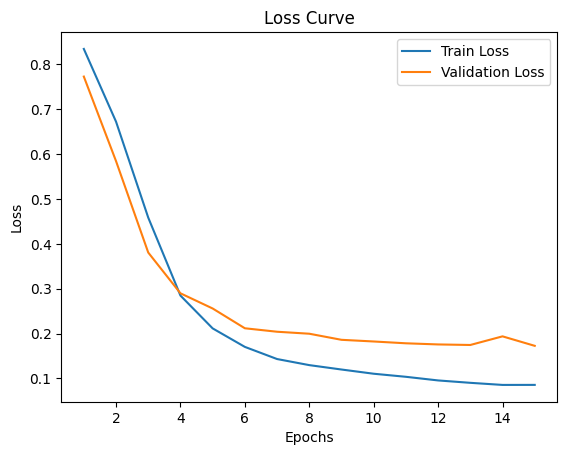

In [22]:
import matplotlib.pyplot as plt

num_epochs = 15
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

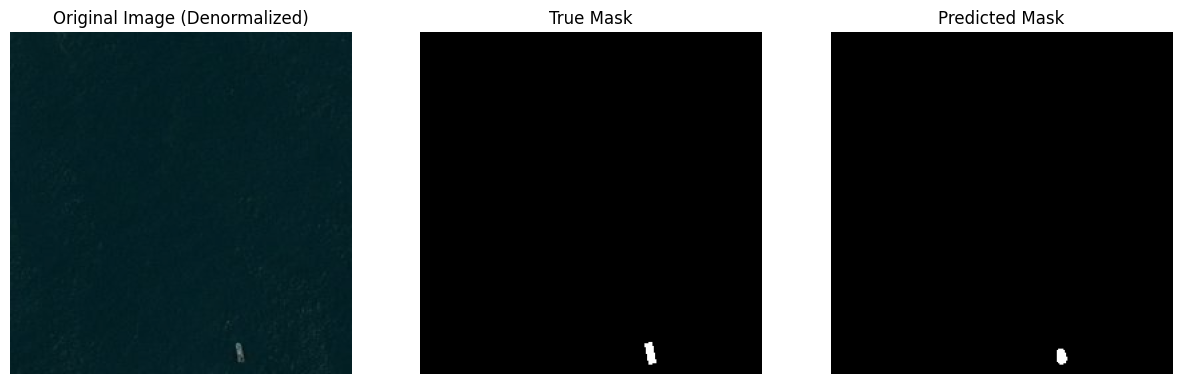

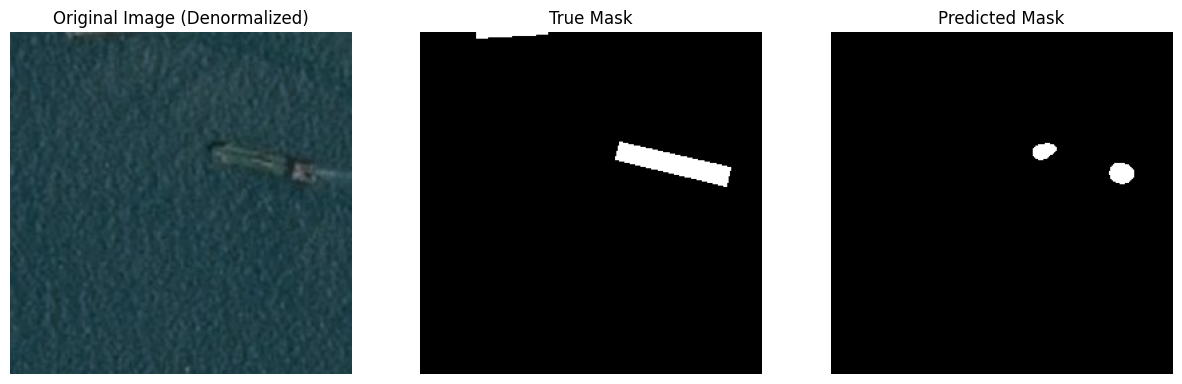

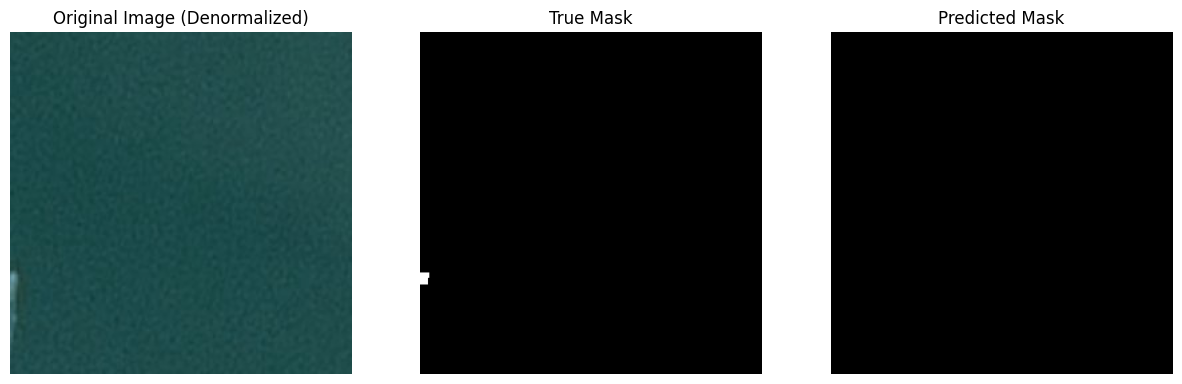

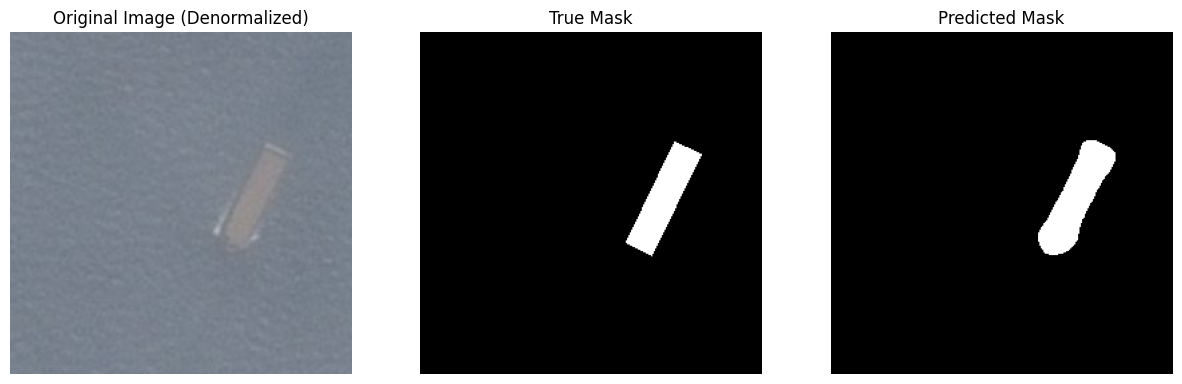

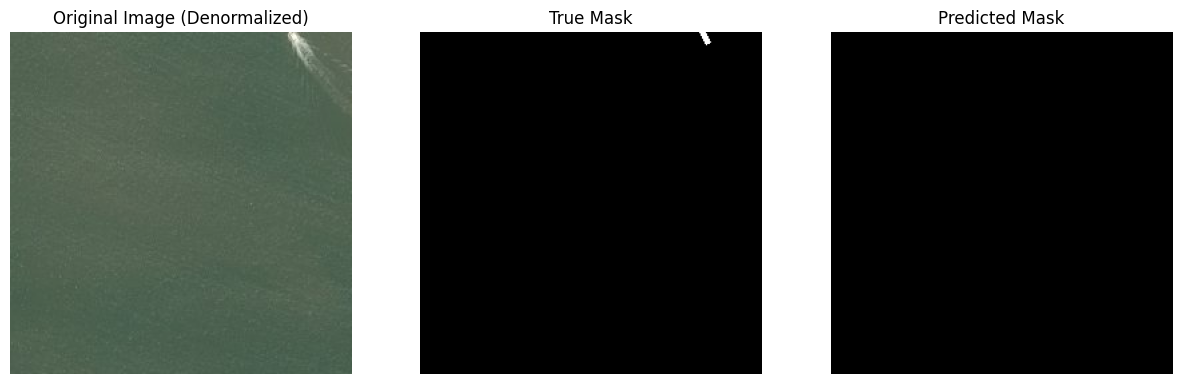

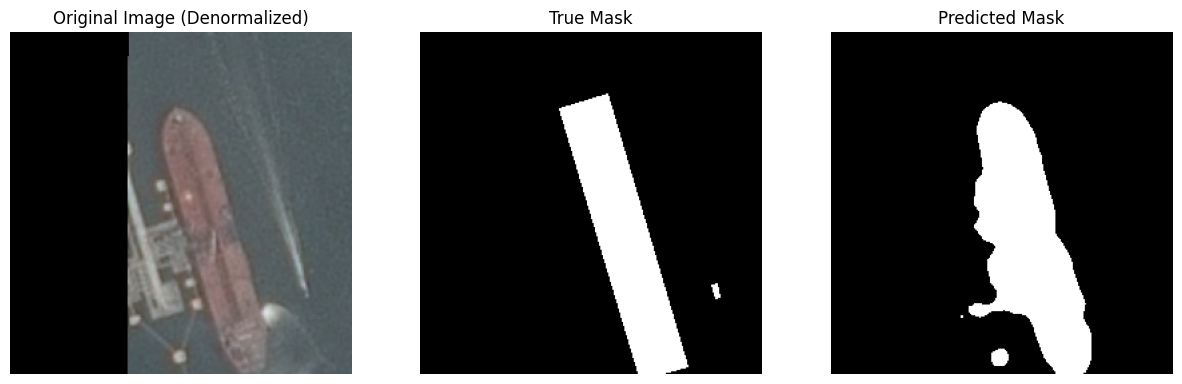

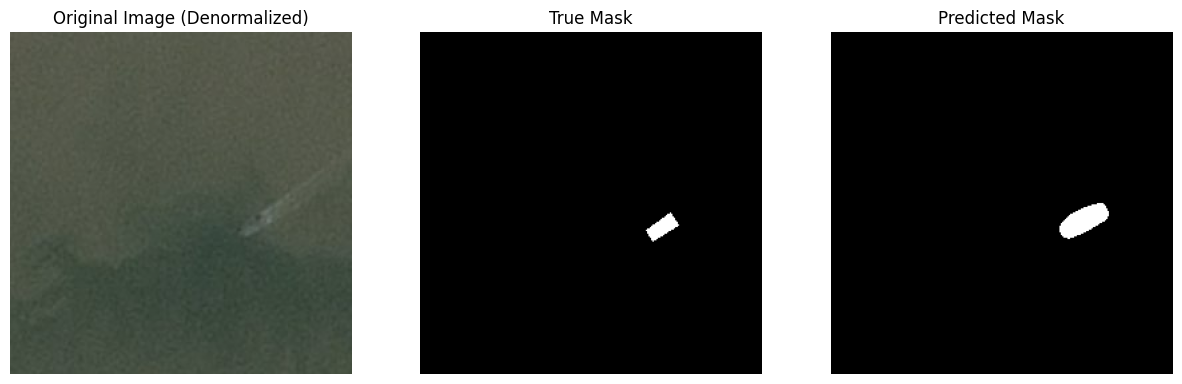

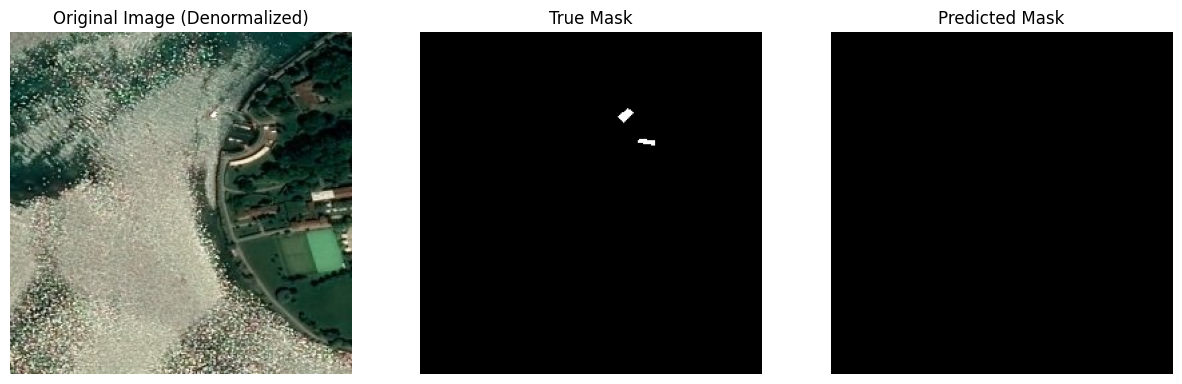

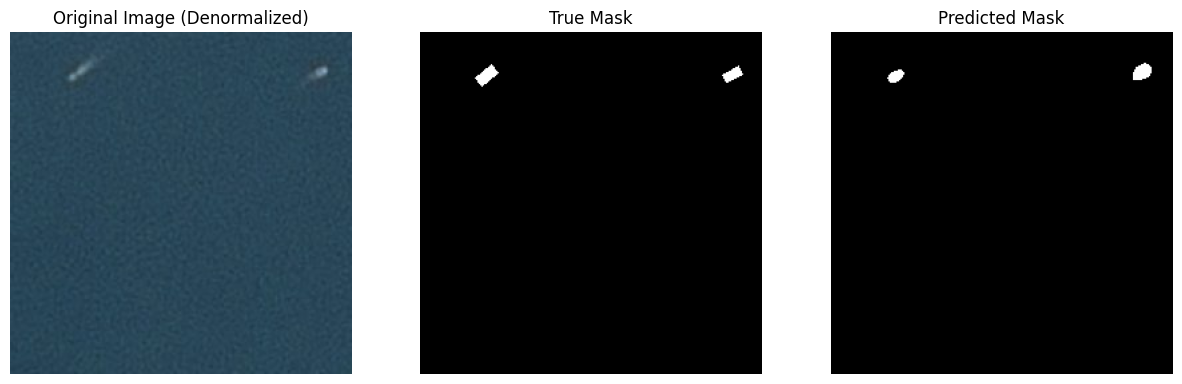

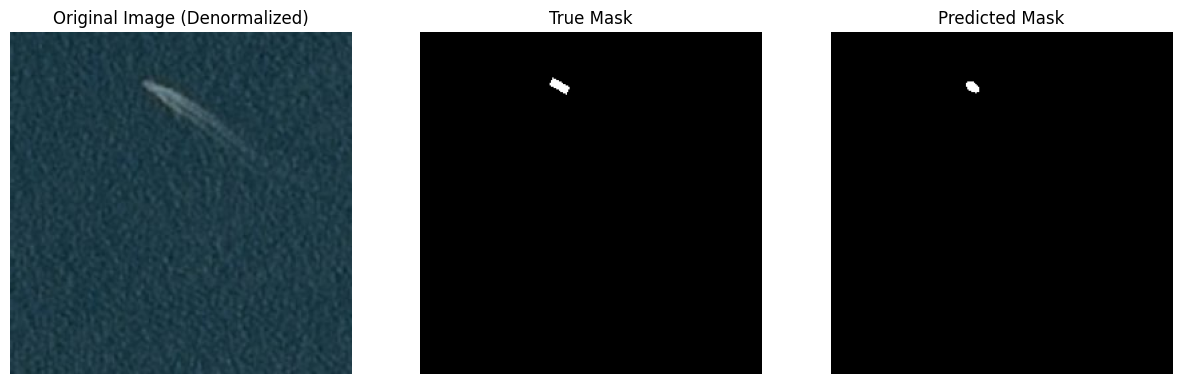

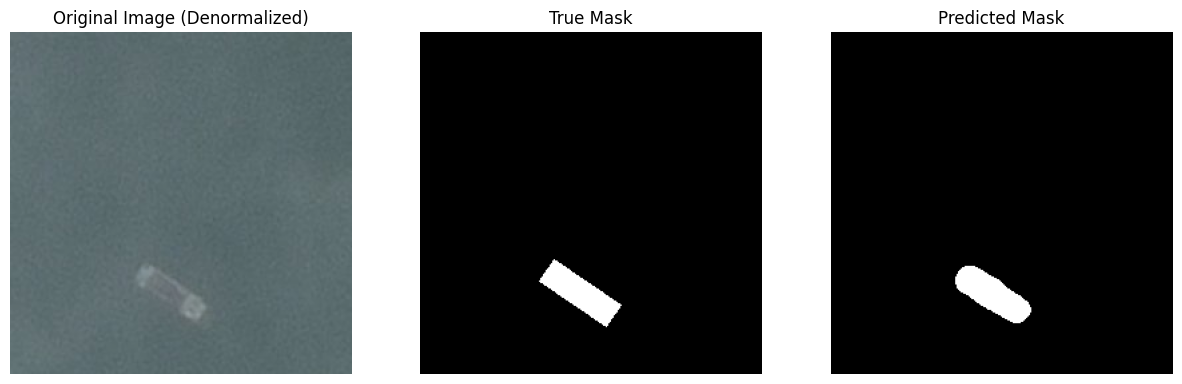

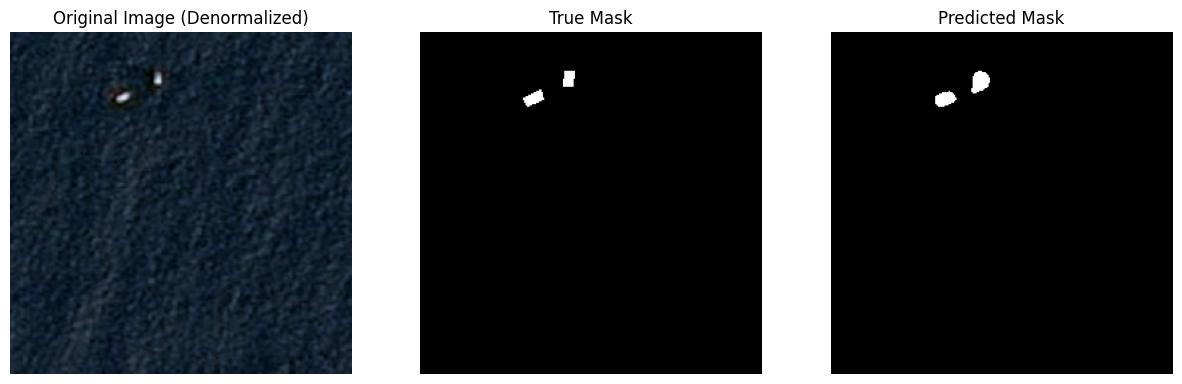

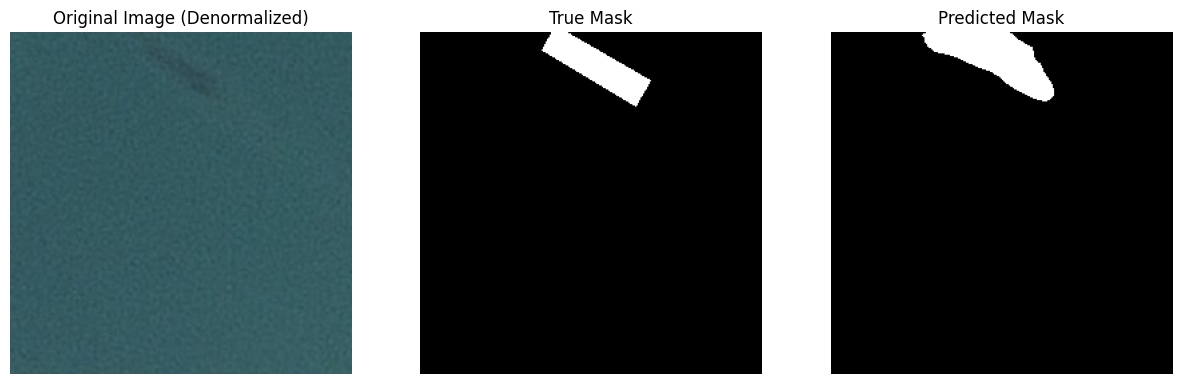

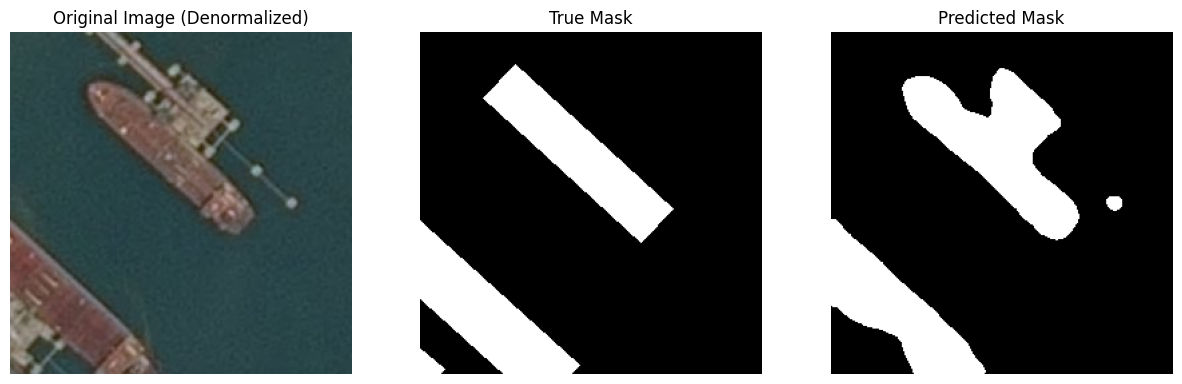

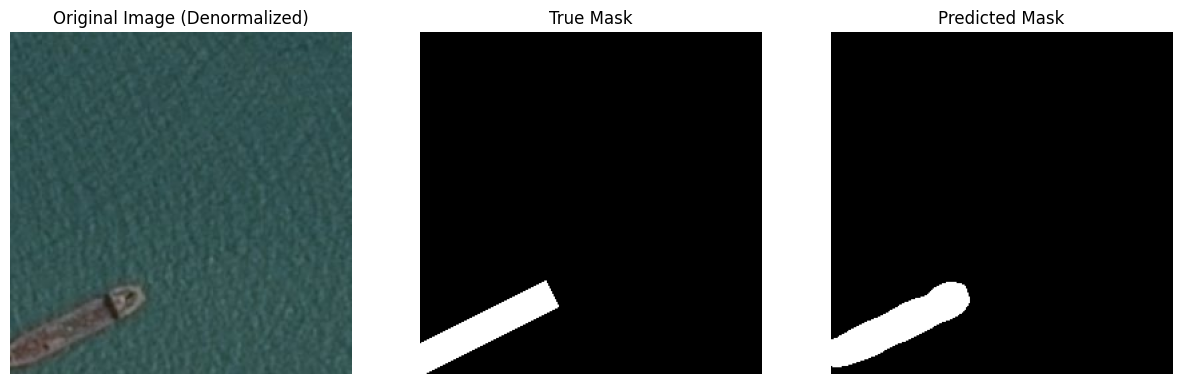

In [23]:
def denormalize_image(image):
    """
    Denormalizes the image after `preprocess_input` on the GPU or CPU.
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # transfer mean and std to the same device where the images are located
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(image.device)

    # Denormalization
    image = image * std + mean  # Reverse scaling
    return image


def visualize_results(model, test_loader, device, num_images=15):
    """
    Visualizes model results on a test dataset using denormalization for images.
    """
    model.eval()  # transfer the model to the evaluation mode
    test_iter = iter(test_loader)
    
    images_shown = 0  
    
    with torch.no_grad():  
        while images_shown < num_images:
            images, true_masks = next(test_iter)
            
            # Convert to float and transfer to GPU
            images = images.to(device).float()  
            true_masks = true_masks.to(device).float() 
            
            # Prediction of masks
            pred_masks = model(images)  # Model call
            pred_masks = torch.sigmoid(pred_masks)  # Apply sigmoid to translate to [0, 1]
            pred_masks = (pred_masks > 0.5).float()  # Let's binarize
            
            # Denormalization of images for visualization
            images_denormalized = denormalize_image(images)
            
            # Visualization
            for j in range(len(images)):
                if images_shown >= num_images:
                    break
                
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image (denormalized)
                ax[0].imshow(images_denormalized[j].cpu().permute(1, 2, 0).clip(0, 1))  # Transfer from GPU to CPU
                ax[0].set_title("Original Image (Denormalized)")
                ax[0].axis("off")
                
                # Real mask
                ax[1].imshow(true_masks[j].cpu().squeeze(), cmap="gray")  # Transfer from GPU to CPU                
                ax[1].set_title("True Mask")
                ax[1].axis("off")
                
                # A mask is provided
                ax[2].imshow(pred_masks[j].cpu().squeeze(), cmap="gray")  # Transfer from GPU to CPU
                ax[2].set_title("Predicted Mask")
                ax[2].axis("off")
                
                images_shown += 1 
                plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
visualize_results(model, test_loader, device, num_images=15)
